# Stock Prediction :
Take stock price of any company you want and predicts its price by using LSTM. Use only Jupyter notebook code.

# importing libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [30]:
from keras.layers import Dense
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping

In [31]:
import datetime

In [32]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score

from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM, Dropout, Dense


In [33]:
import yfinance as yf

In [34]:
start = datetime.datetime(2014,10,1)
end = datetime.datetime(2023,4,20)
data = yf.download(['HDFCBANK.NS'], start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [35]:
data.reset_index(inplace=True)

In [36]:
data['Date'] = data['Date'].dt.date

In [37]:
print(data.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2014-10-01  433.000000  435.575012  430.250000  434.000000  406.950714   
1  2014-10-07  432.500000  433.500000  427.049988  431.225006  404.348724   
2  2014-10-08  430.274994  435.000000  429.149994  433.799988  406.763153   
3  2014-10-09  437.000000  446.475006  434.125000  443.799988  416.139923   
4  2014-10-10  441.524994  442.575012  432.450012  433.649994  406.622528   

    Volume  
0  2935094  
1  2513144  
2  1570192  
3  3825210  
4  2133490  


In [38]:
data = data.loc[:,['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [39]:
data

,Close
Date,
2014-10-01,434.000000
2014-10-07,431.225006
2014-10-08,433.799988
2014-10-09,443.799988
2014-10-10,433.649994
...,...
2023-04-12,1684.900024
2023-04-13,1692.449951
2023-04-17,1666.650024


In [40]:
data.describe()

,Close
count,2106.000000
mean,1028.463248
std,374.170946
min,429.424988
25%,628.987488
50%,1037.687500
75%,1384.149994
max,1695.500000


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-10-01 to 2023-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2106 non-null   float64
dtypes: float64(1)
memory usage: 32.9 KB


# There are no null values in the dataset

# Plotting close price value

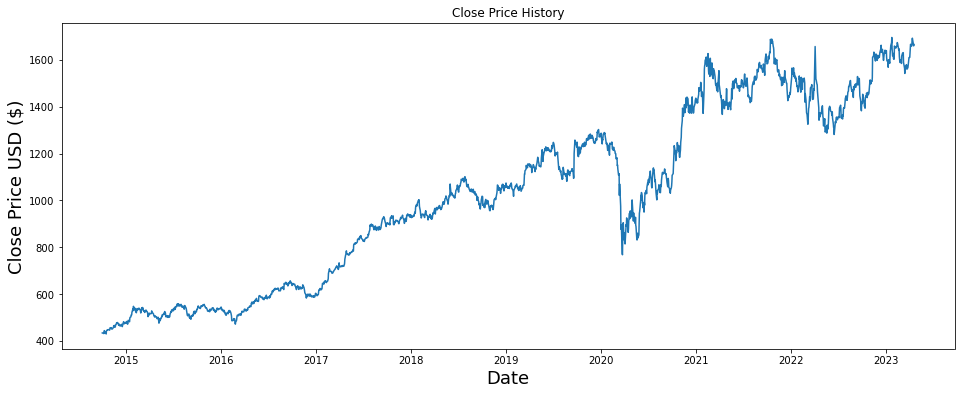

In [42]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [43]:
split_date = pd.Timestamp('2022-01-20')
train = data.loc[:split_date, ['Close']]
test = data.loc[split_date:, ['Close']]

train.shape, test.shape

((1800, 1), (307, 1))

In [44]:
mm = MinMaxScaler()
trains = mm.fit_transform(train)
tests = mm.transform(test)

train = pd.DataFrame(trains, columns=['Close'])
test = pd.DataFrame(tests, columns=['Close'])

In [45]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, train.shape[0]):
    X_train.append(train.iloc[i-60:i, 0])
    y_train.append(train.iloc[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

## Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (X_train.shape[0], 1,1))
X_train.shape, y_train.shape

((1740, 60, 1), (1740, 1, 1))

the loop iterates over the rows of the train DataFrame to create the input-output pairs for training. The previous 60 values are used as the input sequence, and the value at the ith row is used as the output.

In [46]:
# Creating a data structure with 60 timesteps and 1 output
X_test = []
y_test = []

for i in range(60, test.shape[0]):
    X_test.append(test.iloc[i-60:i,0])
    y_test.append(test.iloc[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)

## Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape, y_test.shape

((247, 60, 1), (247,))

the loop iterates over the rows of the test DataFrame to create the input-output pairs for testing. Similar to the training code snippet, the previous 60 values are used as the input sequence, and the value at the ith row is used as the output

# Building LSTM

In [47]:
early_stop = EarlyStopping(monitor='loss', patience=2)

In [48]:
K.clear_session()

lstm_model = Sequential()

lstm_model.add(LSTM(100, return_sequences=True, input_shape=(60,1)))

lstm_model.add(LSTM(50, return_sequences=True))

lstm_model.add(LSTM(50, return_sequences=True))

lstm_model.add(LSTM(50))

# The output layer
lstm_model.add(Dense(units=1, activation='relu'))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 111,451
Trainable params: 111,451
Non-trainable params: 0
_________________________________________________________________


In [49]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (X_train.shape[0], ))
X_train.shape, y_train.shape

((1740, 60, 1), (1740,))

In [50]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (X_test.shape[0], ))
X_test.shape, y_test.shape

((247, 60, 1), (247,))

In [51]:
hist2 = lstm_model.fit(X_train, y_train, batch_size=16, epochs=100, callbacks=[early_stop])

Epoch 1/100
109/109 [==============================] - 27s 111ms/step - loss: 0.0101
Epoch 2/100
109/109 [==============================] - 12s 108ms/step - loss: 0.0017
Epoch 3/100
109/109 [==============================] - 12s 108ms/step - loss: 0.0014
Epoch 4/100
109/109 [==============================] - 15s 135ms/step - loss: 0.0013
Epoch 5/100
109/109 [==============================] - 12s 111ms/step - loss: 0.0013
Epoch 6/100
109/109 [==============================] - 12s 107ms/step - loss: 0.0011
Epoch 7/100
109/109 [==============================] - 12s 114ms/step - loss: 9.4173e-04
Epoch 8/100
109/109 [==============================] - 12s 114ms/step - loss: 0.0011
Epoch 9/100
109/109 [==============================] - 13s 121ms/step - loss: 9.5055e-04


In [55]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the test data
y_pred = lstm_model.predict(X_test)

# Flatten the predicted and actual values
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("MAPE:", mape)

print("RMSE:", rmse)
print("R2 Score:", r2)

8/8 [==============================] - 0s 55ms/step
MAPE: 2.9052606447418574
RMSE: 0.03167126592369725
R2 Score: 0.8851946882477635


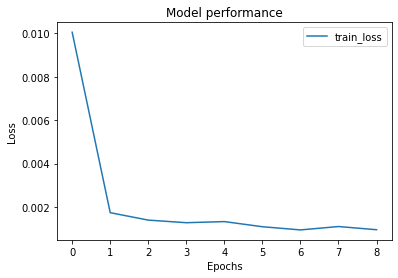

In [53]:
# Plot the behavior of loss and accuracy with epochs
plt.plot(hist2.history['loss'], label='train_loss')
plt.title('Model performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

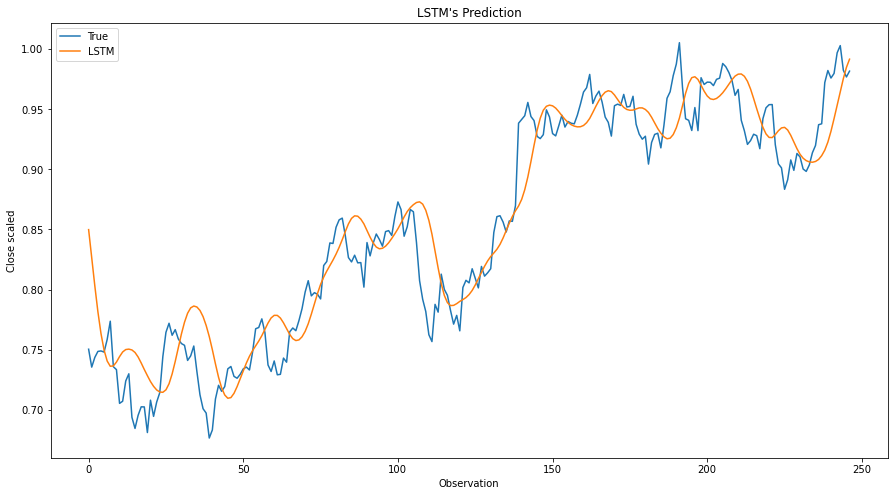

In [56]:
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Close scaled')
plt.legend()
plt.show();

As per the plotted graph of predicted and actual stock prices, predicted curve is approximately following the actual line and smooth, it typically indicates that the model has captured the underlying patterns and trends in the data effectively. A smooth predicted curve suggests that the model is able to make reasonably accurate predictions and is capable of capturing the overall behavior and dynamics of the time period. It suggests that the model is able to generalize well and produce coherent predictions that align with the underlying patterns observed in the historical data. From the plot, it is evident to a certain extent that it is not underfitting or overfitting.
From the quantitative evaluation of the model's performance using metrics, the mape was found to be around 2.9%. So It can be inferred that the developed lstm model was effective in predicting the stock price well.